##**Introduction**

With humble beginning that trace to late 19th century Japan, Anime has become global phenomenon captivating audiences.  As the number of titles grows, discovering new titles can be overwhelming.  This is where an anime recommender system can be beneficial.  

Our aim is to design a system to enhance the user’s experience by suggesting relevant shows and movies based on their taste and behavior patterns.  By analyzing viewer history, ratings, and behavior, we can identify patterns and similarities that could lead users to new titles. 

In this project, we focus on  building a content-based recommendation system. This system generates suggestions based on content that another user has previously enjoyed.  By using cosine similarity, we can compare features and identify those that match a user's interest and taste.  The goal is to create a way for users to discover new anime.  To evaluate the success of our recommendation system, we will test it out with members of our team and classmates.


##**What is a Recommendation System?**

A recommendation system is an algorithm designed to suggest relevant products to a user based on the user’s behaviors, similarities with another user, and interests.  Products can include books, music, videos, customer satisfaction, etc.   


##**How does it work?**

It begins with access to user data. Next, a content-based matrix is created based on the viewed anime titles and their ratings. A weighted feature matrix is computed using the user's matrix and the matrix containing all titles. This weighted features matrix is calculated using a similarity algorithm like cosine similarity, which determines how similar two vectors are to one another. The formula is as follows:

Cosine Similarity Formula:

$Cosine Similarity(x,y) = \frac{x \cdot y}{||x|| \cdot ||y||}$


where:
- $ x \cdot y$ is the dot product of vectors $x$ and $y$,
- $||x||$ is the magnitude (norm) of vector $x$,
- $(||y||)$ is the magnitude (norm) of vector $y$.


It measures the cosine of the angle between the vectors and produces a value between -1 and 1. A value of 1 suggests that 𝑥 and 𝑦 are very similar in tastes. A value of 0 suggests that 𝑥 and 𝑦 don’t share any interests, while a value of -1 suggests that 𝑥 and 𝑦 have opposite interests.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


C:\Users\mattb\anaconda3\envs\recommender\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rating_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv')

In [3]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
rating_df.shape

(7813737, 3)

In [5]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [6]:
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
anime_df.shape

(12294, 7)

In [9]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [10]:
anime_df = anime_df.dropna()

In [11]:
genre_split = anime_df['genre'].str.split(',', expand=True)

anime_df['genre_1'] = genre_split[0].str.strip().str.lower()
anime_df['genre_2'] = genre_split[1].str.strip().str.lower()
anime_df['genre_3'] = genre_split[2].str.strip().str.lower()

In [12]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,drama,romance,school
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,action,adventure,drama
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,action,comedy,historical
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,sci-fi,thriller,None
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,action,comedy,historical


In [13]:
anime_df['genre_1'].unique()

array(['drama', 'action', 'sci-fi', 'comedy', 'adventure', 'fantasy',
       'mystery', 'psychological', 'ecchi', 'josei', 'military',
       'romance', 'demons', 'dementia', 'music', 'game', 'cars', 'mecha',
       'horror', 'school', 'historical', 'kids', 'shounen', 'shoujo',
       'magic', 'harem', 'martial arts', 'sports', 'slice of life',
       'seinen', 'parody', 'police', 'thriller', 'supernatural',
       'samurai', 'super power', 'vampire', 'space', 'hentai', 'yaoi'],
      dtype=object)

In [14]:
anime_df['genre_2'].unique()

array(['romance', 'adventure', 'comedy', 'thriller', 'drama', 'military',
       'fantasy', 'school', 'music', 'slice of life', 'mecha', 'mystery',
       'horror', 'police', 'parody', 'seinen', 'psychological', 'sci-fi',
       'demons', 'historical', 'sports', 'supernatural', 'game', 'magic',
       'josei', 'shounen', 'harem', 'cars', 'dementia', None, 'shoujo',
       'kids', 'samurai', 'ecchi', 'shoujo ai', 'super power',
       'martial arts', 'shounen ai', 'space', 'vampire', 'hentai', 'yaoi',
       'yuri'], dtype=object)

In [15]:
anime_df['genre_3'].unique()

array(['school', 'drama', 'historical', None, 'shounen', 'sci-fi',
       'romance', 'mecha', 'supernatural', 'military', 'comedy', 'parody',
       'fantasy', 'shoujo', 'mystery', 'psychological', 'sports',
       'seinen', 'horror', 'josei', 'slice of life', 'music',
       'shounen ai', 'ecchi', 'demons', 'magic', 'vampire', 'police',
       'martial arts', 'space', 'super power', 'dementia', 'shoujo ai',
       'thriller', 'harem', 'kids', 'samurai', 'game', 'cars', 'yaoi',
       'hentai', 'yuri'], dtype=object)

In [16]:
anime_df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [17]:
anime_df.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [18]:
def removeOutliers(df, column, lower_quartile=0.25, upper_quartile=0.75, multiplier=1.5, direction='both'):
    """
    Removes outliers from a DataFrame based on the IQR method for a specified column.
    
    Parameters:
    - df (DataFrame): The DataFrame to process.
    - column (str): The column to assess for outliers.
    - lower_quartile (float): The lower quartile (default: 0.25).
    - upper_quartile (float): The upper quartile (default: 0.75).
    - multiplier (float): The multiplier for the IQR (default: 1.5).
    - direction (str): 'both', 'low', or 'high' to specify which outliers to remove.
    
    Returns:
    - DataFrame: A new DataFrame with outliers removed.
    """
    # Calculate the quartiles and IQR
    Q1 = df[column].quantile(lower_quartile)
    Q3 = df[column].quantile(upper_quartile)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    
    # Filter based on direction
    if direction == 'low':
        return df[df[column] >= lower_bound]
    elif direction == 'high':
        return df[df[column] <= upper_bound]
    else:
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [19]:
anime_df = removeOutliers(anime_df, column='members', direction='low')

In [20]:
df = rating_df.merge(anime_df, on='anime_id', how='left')
df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,genre_1,genre_2,genre_3
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,action,comedy,martial arts
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,comedy,romance,school
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0,comedy,drama,ecchi
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0,action,drama,horror
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0,comedy,ecchi,fantasy


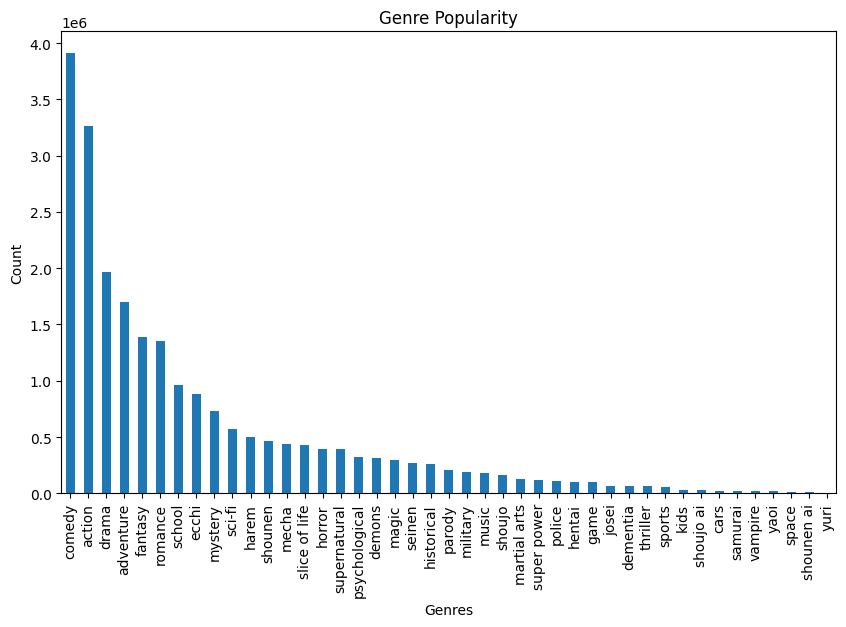

In [21]:
genres = pd.concat([df['genre_1'], df['genre_2'], df['genre_3']]).dropna()
genre_counts = genres.value_counts()

genre_counts.plot(kind='bar', figsize=(10, 6), title='Genre Popularity')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

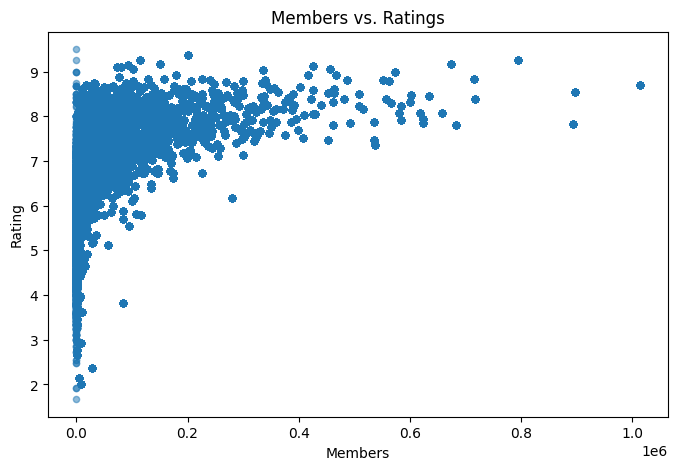

In [22]:
# Scatter plot
df.plot.scatter(x='members', y='rating_y', alpha=0.5, figsize=(8, 5), title='Members vs. Ratings')
plt.xlabel('Members')
plt.ylabel('Rating')
plt.show()

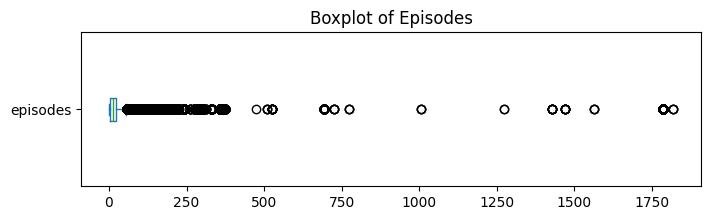

In [23]:
# Boxplot
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'].plot(kind='box', vert=False, figsize=(8, 2), title='Boxplot of Episodes')
plt.show()

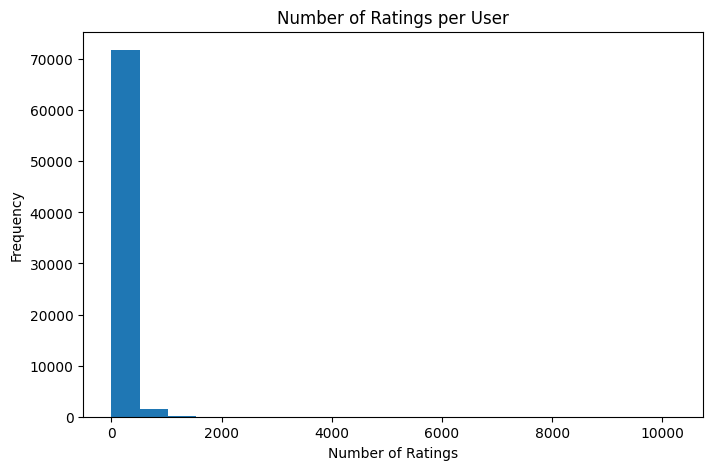

In [24]:
# Ratings per user
user_ratings = df.groupby('user_id')['anime_id'].count()
user_ratings.plot(kind='hist', bins=20, figsize=(8, 5), title='Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

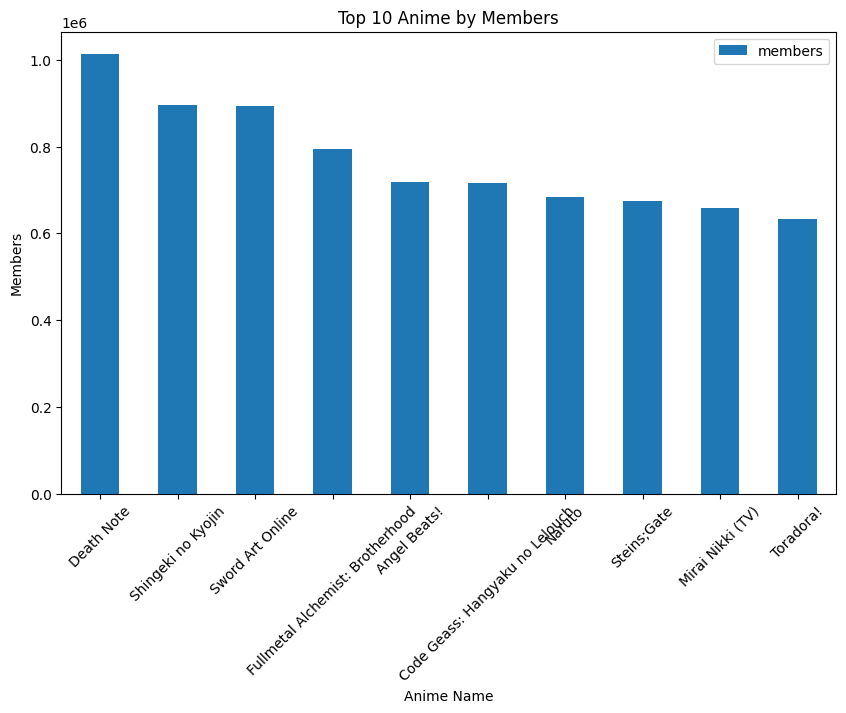

In [25]:
# Top 10 most popular anime by members
top_anime = df[['name', 'members']].drop_duplicates().sort_values(by='members', ascending=False).head(10)
top_anime.plot(x='name', y='members', kind='bar', figsize=(10, 6), title='Top 10 Anime by Members')
plt.xlabel('Anime Name')
plt.ylabel('Members')
plt.xticks(rotation=45)
plt.show()

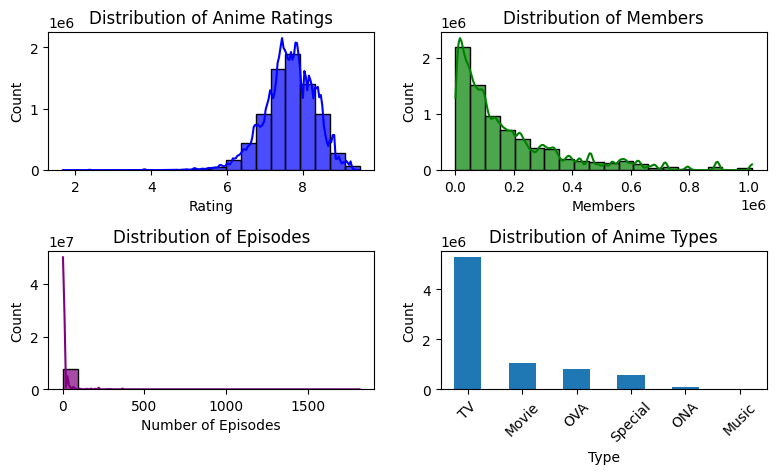

In [26]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating_y'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Histogram and KDE for Episodes Distribution
sns.histplot(df['episodes'].dropna(), bins=20, kde=True, ax=axes[1, 0], color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes')
axes[1, 0].set_xlabel('Number of Episodes')
axes[1, 0].set_ylabel('Count')

# Bar Chart for Type Distribution (no KDE)
type_counts = df['type'].value_counts()
type_counts.plot(kind='bar', figsize=(8, 5), title='Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


In [27]:
def categorize_content(row):
    if   row['episodes'] == 1: return 'Movie/Short Film'
    elif row['episodes'] <= 12: return '<=12 Episodes'
    elif row['episodes'] <= 24: return '<=24 Episodes'
    else: return '>24 Episodes'

df['episodes_categorical'] = df.apply(categorize_content, axis=1)

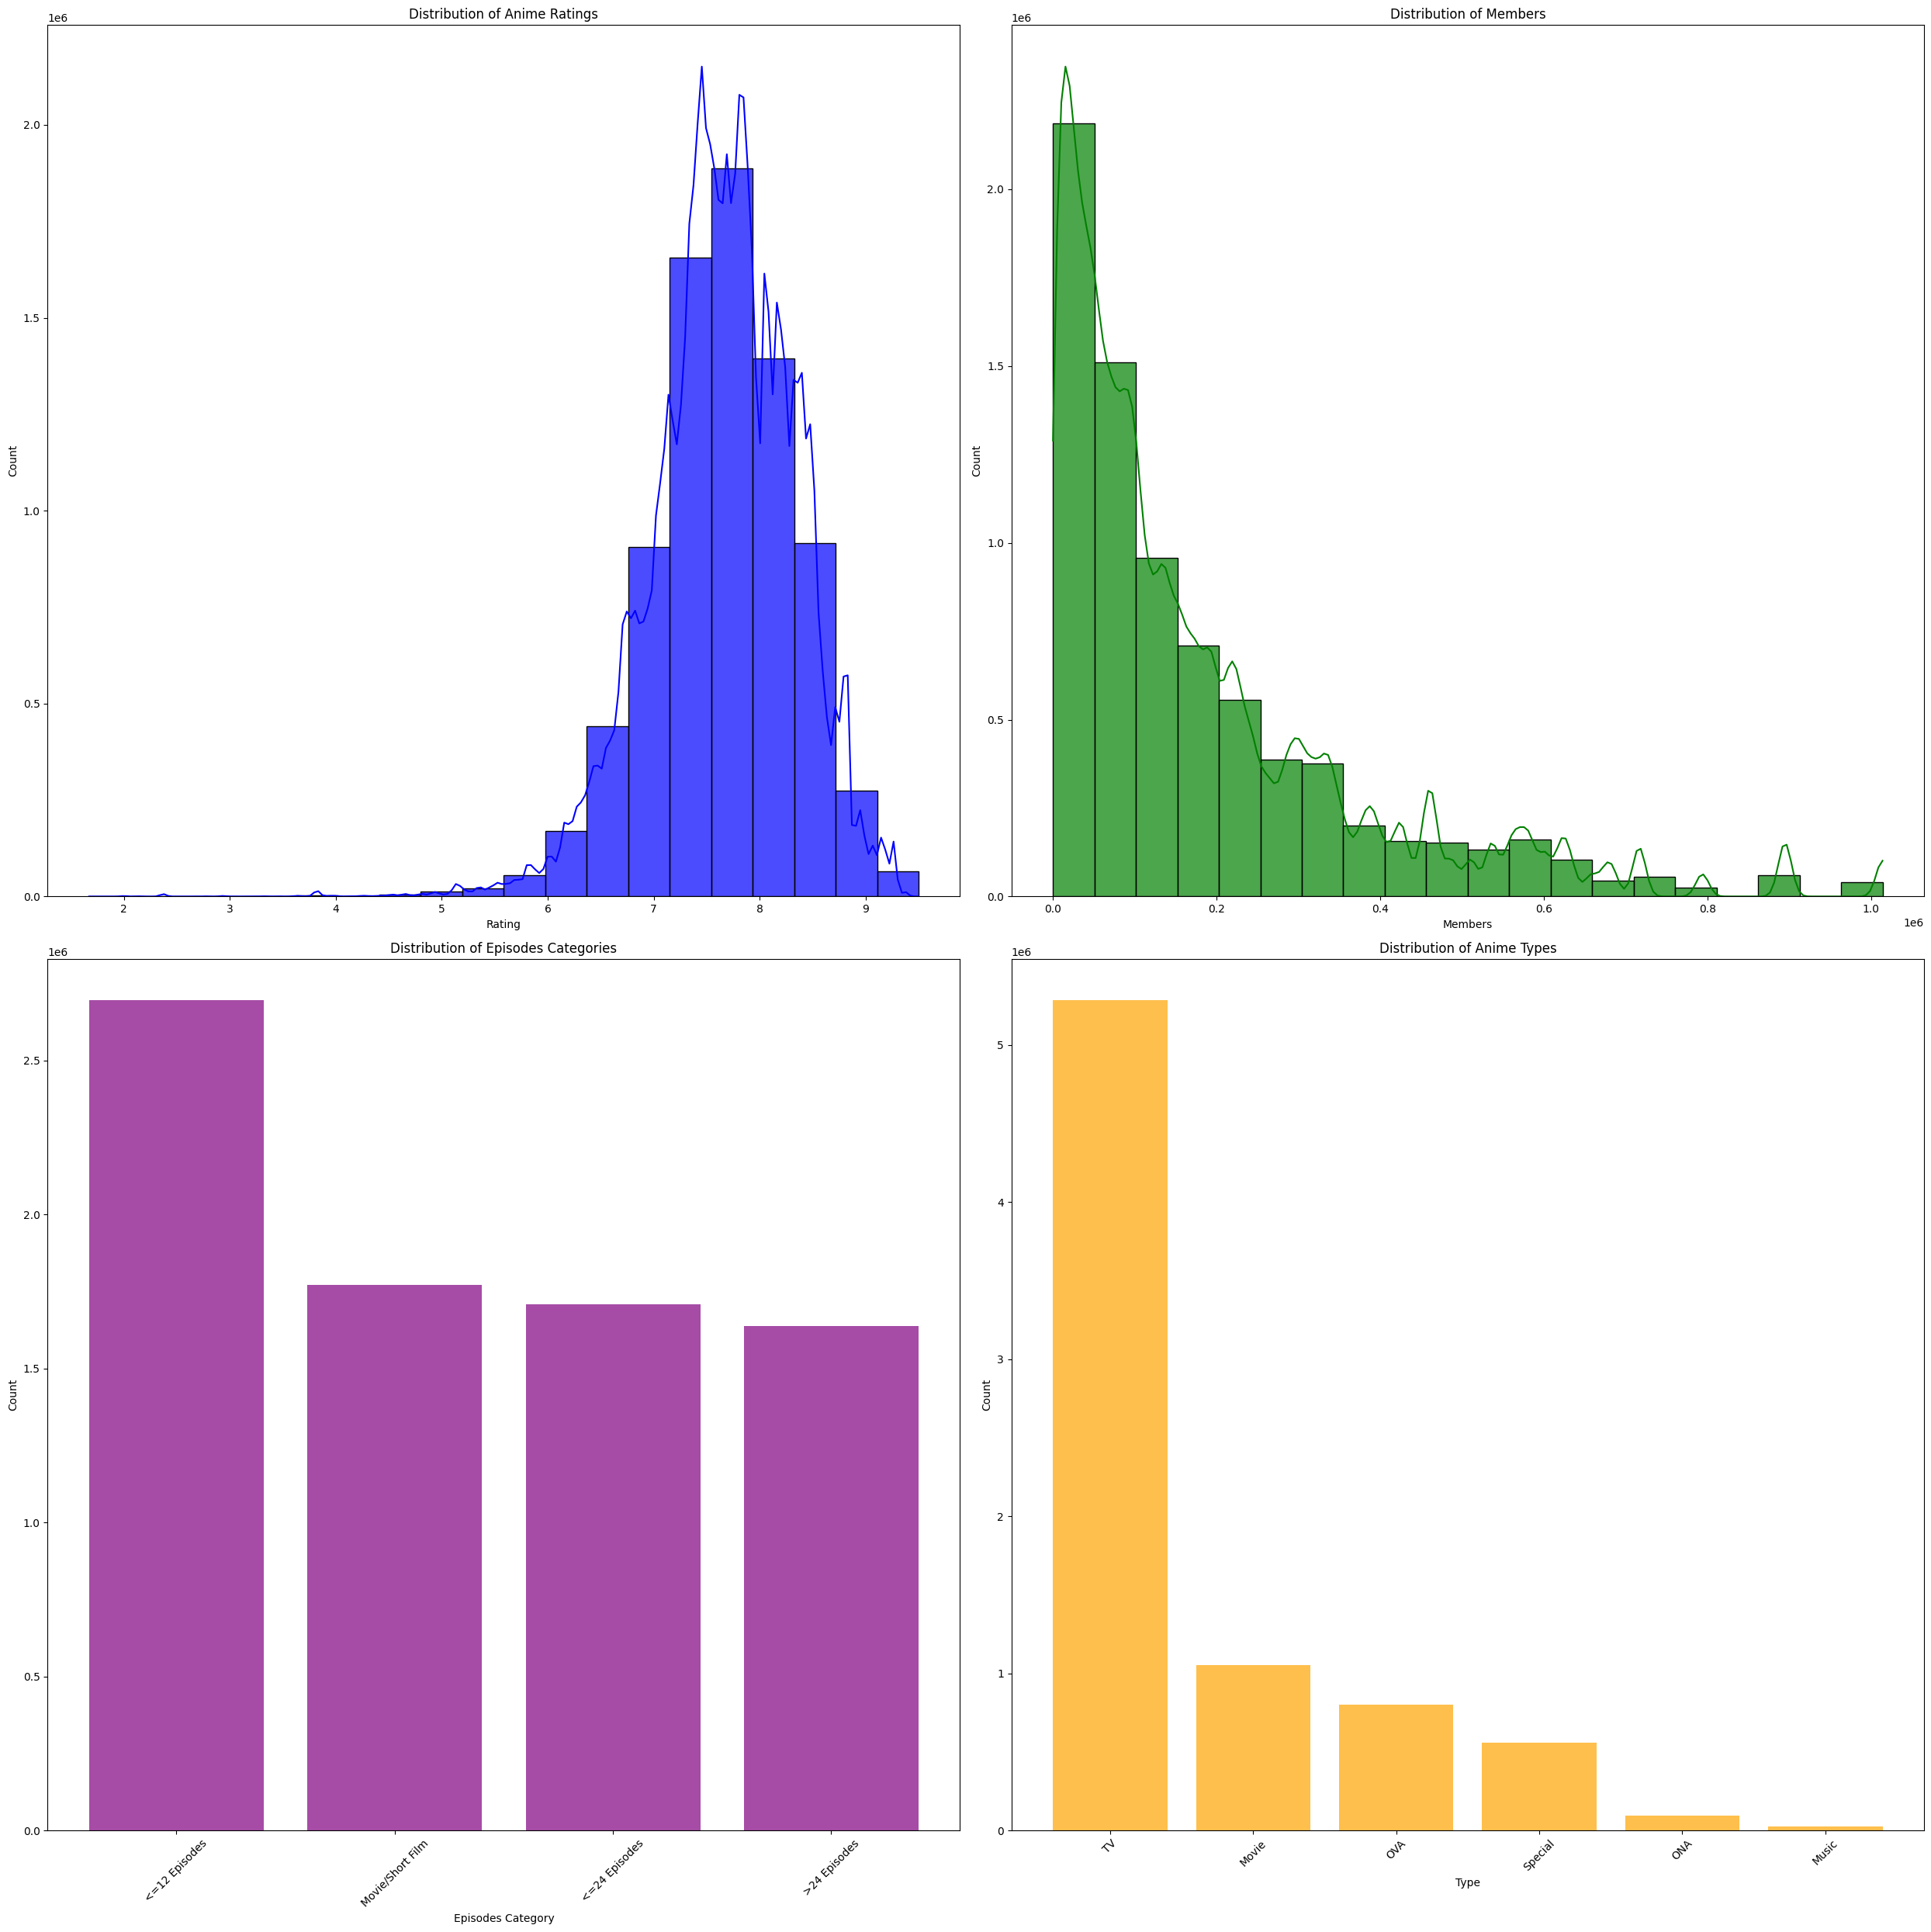

In [28]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(25, 25))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating_y'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Bar Chart for Episodes Categorical Distribution
episodes_counts = df['episodes_categorical'].value_counts()
axes[1, 0].bar(episodes_counts.index, episodes_counts.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes Categories')
axes[1, 0].set_xlabel('Episodes Category')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Bar Chart for Type Distribution
type_counts = df['type'].value_counts()
axes[1, 1].bar(type_counts.index, type_counts.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [29]:
df['type'].value_counts()

type
TV         5283596
Movie      1051909
OVA         800307
Special     559347
ONA          91952
Music        26500
Name: count, dtype: int64

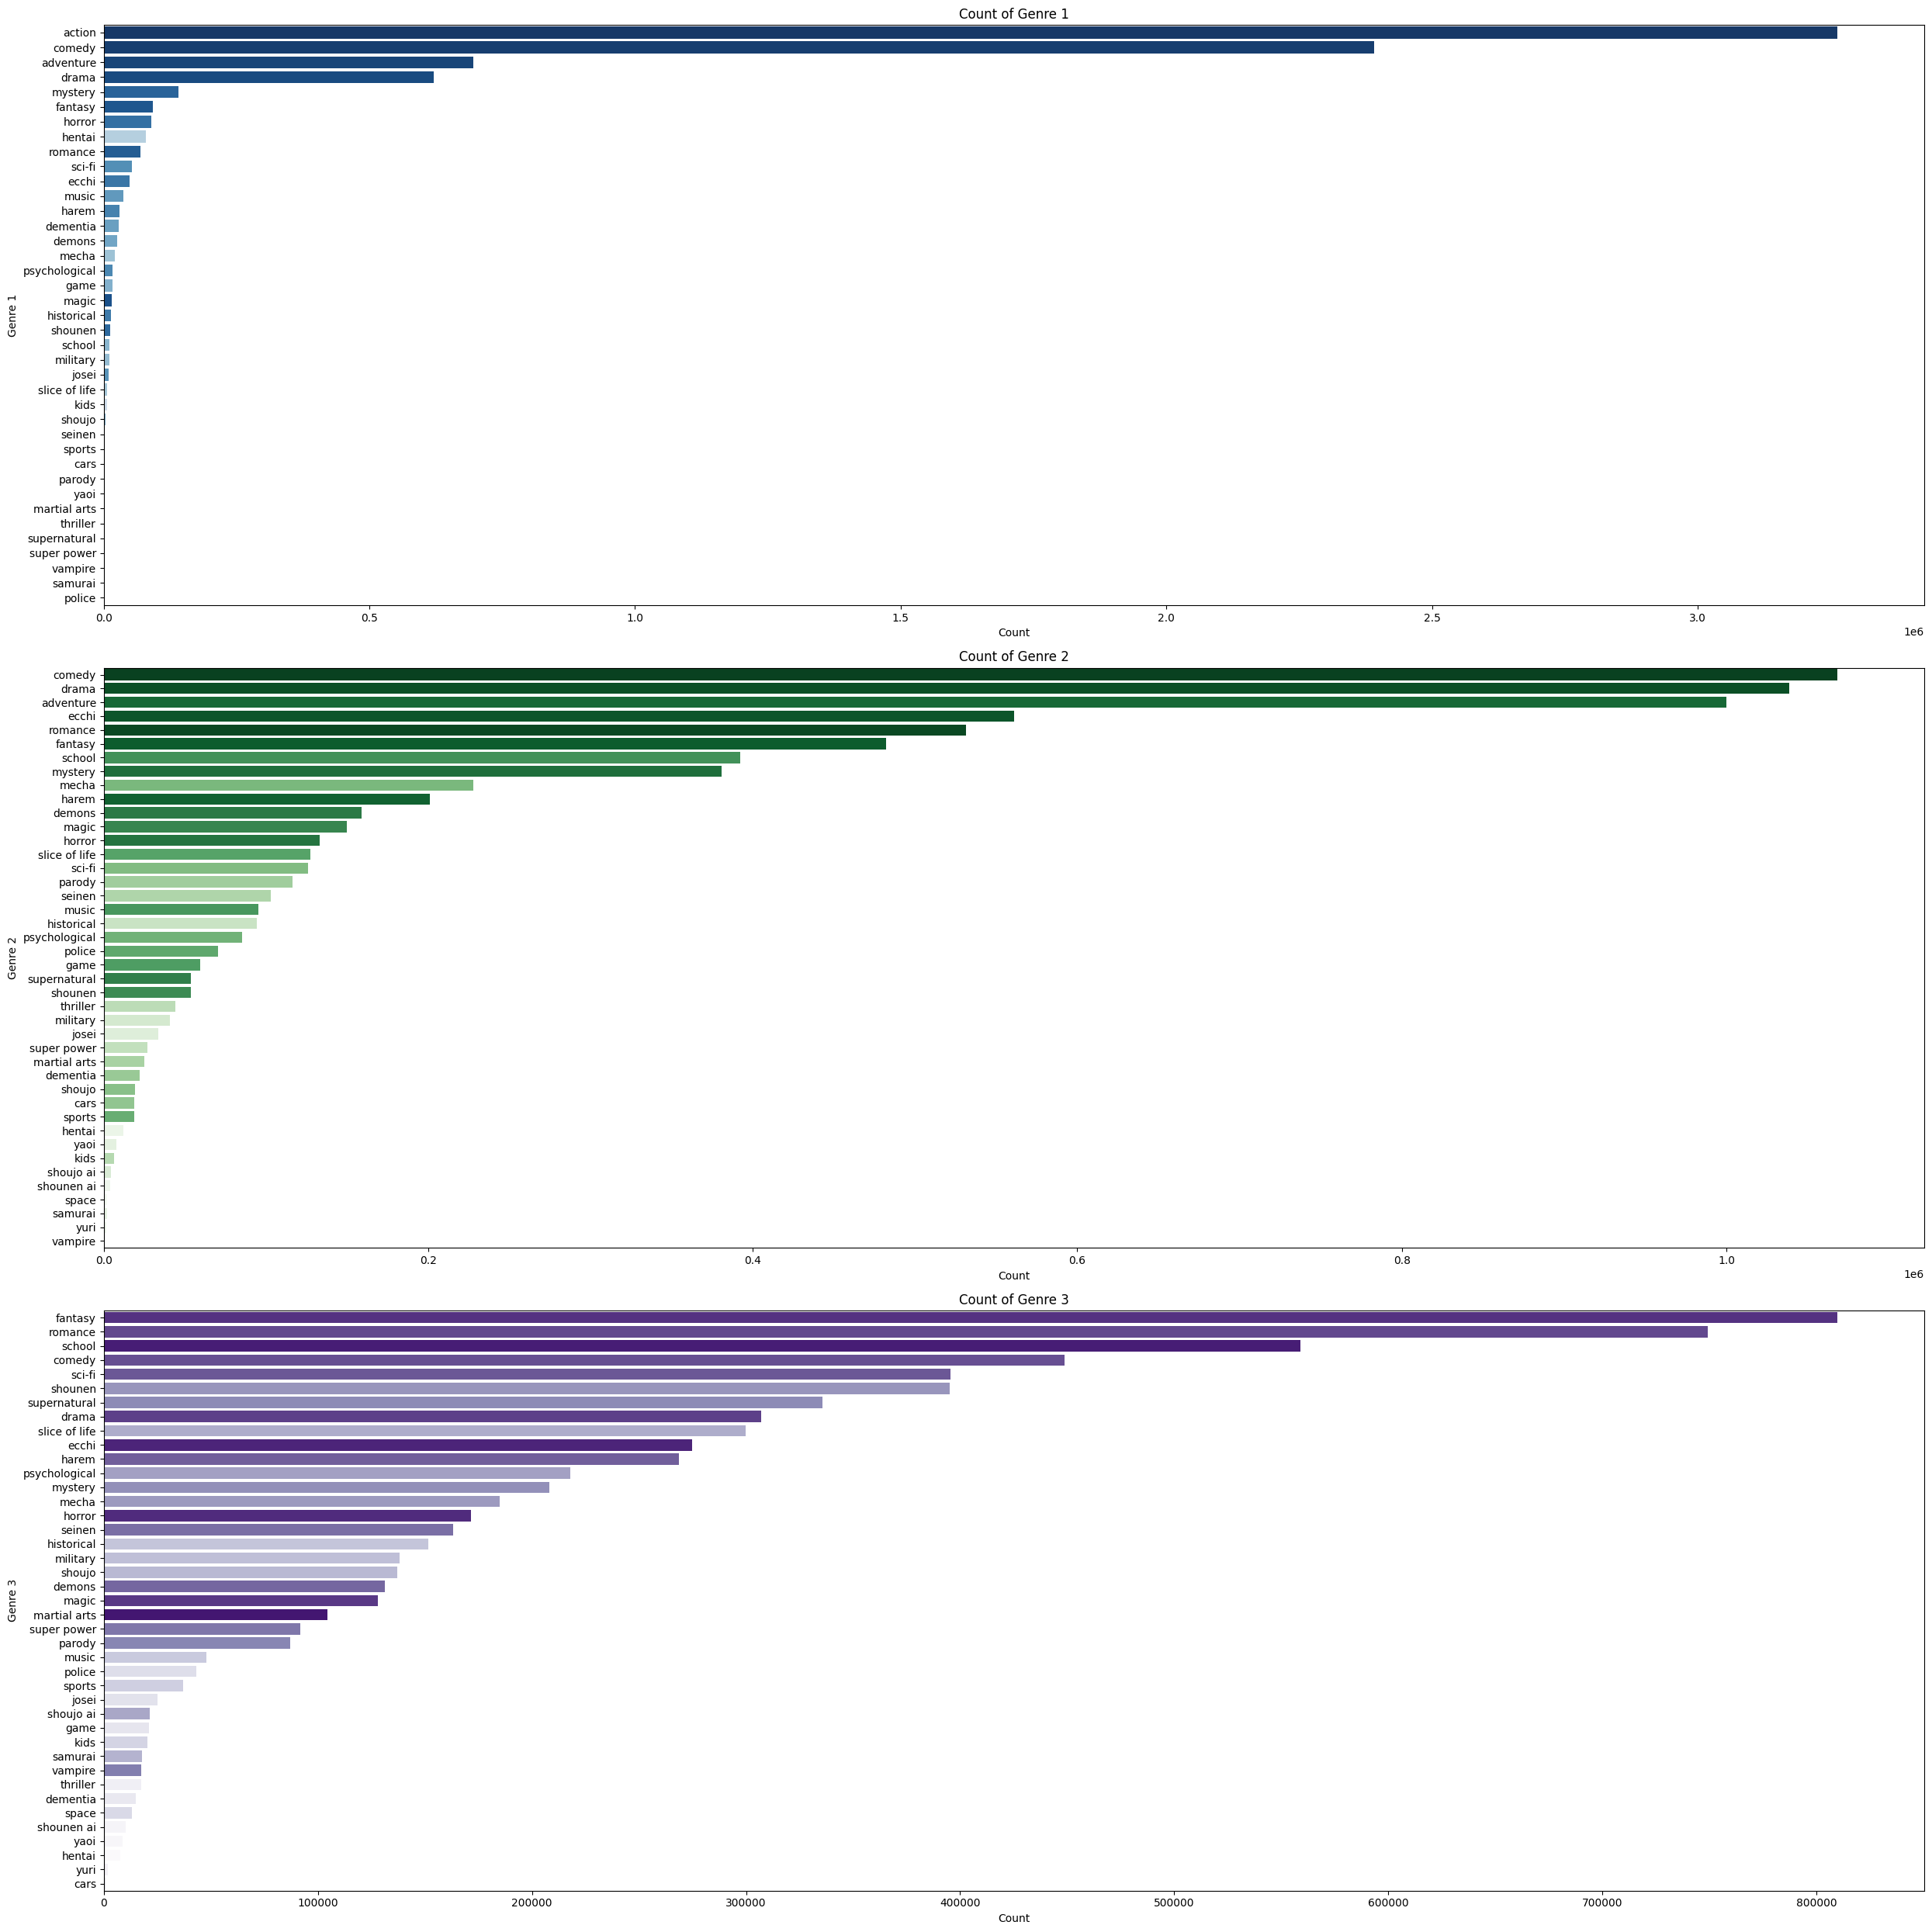

In [30]:
# Set up a figure with subplots (1 plot per row)
fig, axes = plt.subplots(3, 1, figsize=(25, 25))  # 3 rows, 1 column

# Countplot for genre_1
sns.countplot(data=df, y='genre_1', ax=axes[0], order=df['genre_1'].value_counts().index, palette='Blues_r', hue=df['genre_1'], legend=False)
axes[0].set_title('Count of Genre 1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre 1')

# Countplot for genre_2
sns.countplot(data=df, y='genre_2', ax=axes[1], order=df['genre_2'].value_counts().index, palette='Greens_r', hue=df['genre_2'], legend=False)
axes[1].set_title('Count of Genre 2')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Genre 2')

# Countplot for genre_3
sns.countplot(data=df, y='genre_3', ax=axes[2], order=df['genre_3'].value_counts().index, palette='Purples_r', hue=df['genre_3'], legend=False)
axes[2].set_title('Count of Genre 3')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Genre 3')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


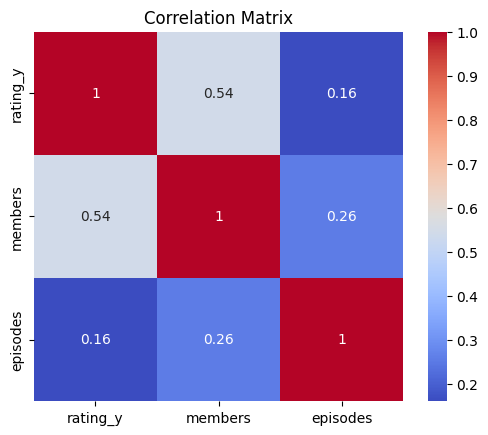

In [31]:
correlation_matrix = df[['rating_y', 'members', 'episodes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [32]:
df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,genre_1,genre_2,genre_3,episodes_categorical
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,action,comedy,martial arts,>24 Episodes
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,comedy,romance,school,>24 Episodes
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,comedy,drama,ecchi,<=24 Episodes
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,action,drama,horror,<=24 Episodes
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,comedy,ecchi,fantasy,<=12 Episodes


In [33]:
for x in df.columns: print(x)

user_id
anime_id
rating_x
name
genre
type
episodes
rating_y
members
genre_1
genre_2
genre_3
episodes_categorical


In [34]:
# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[['type', 'genre_1', 'genre_2', 'genre_3']])

# Create a DataFrame for the encoded features
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

# Define the mapping
ordinal_mapping = {
    'Movie/Short Film': 0,
    '<=12 Episodes': 1,
    '<=24 Episodes': 2,
    '>24 Episodes': 4
}

# Apply the mapping
df['episodes_categorical'] = df['episodes_categorical'].map(ordinal_mapping)
df = pd.concat([df, one_hot_df], axis=1)


In [35]:
df['type'].unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', nan], dtype=object)

In [36]:
scaler = MinMaxScaler()
df[['episodes', 'rating_y', 'members']] = scaler.fit_transform(df[['episodes', 'rating_y', 'members']])

In [37]:
df['interaction'] = df['rating_x'].apply(lambda x: 0 if x == -1 else 1)
df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,genre_1,genre_2,genre_3,episodes_categorical,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_nan,genre_1_action,genre_1_adventure,genre_1_cars,genre_1_comedy,genre_1_dementia,genre_1_demons,genre_1_drama,genre_1_ecchi,genre_1_fantasy,genre_1_game,genre_1_harem,genre_1_hentai,genre_1_historical,genre_1_horror,genre_1_josei,genre_1_kids,genre_1_magic,genre_1_martial arts,genre_1_mecha,genre_1_military,genre_1_music,genre_1_mystery,genre_1_parody,genre_1_police,genre_1_psychological,genre_1_romance,genre_1_samurai,genre_1_school,genre_1_sci-fi,genre_1_seinen,genre_1_shoujo,genre_1_shounen,genre_1_slice of life,genre_1_sports,genre_1_super power,genre_1_supernatural,genre_1_thriller,genre_1_vampire,genre_1_yaoi,genre_1_nan,genre_2_adventure,genre_2_cars,genre_2_comedy,genre_2_dementia,genre_2_demons,genre_2_drama,genre_2_ecchi,genre_2_fantasy,genre_2_game,genre_2_harem,genre_2_hentai,genre_2_historical,genre_2_horror,genre_2_josei,genre_2_kids,genre_2_magic,genre_2_martial arts,genre_2_mecha,genre_2_military,genre_2_music,genre_2_mystery,genre_2_parody,genre_2_police,genre_2_psychological,genre_2_romance,genre_2_samurai,genre_2_school,genre_2_sci-fi,genre_2_seinen,genre_2_shoujo,genre_2_shoujo ai,genre_2_shounen,genre_2_shounen ai,genre_2_slice of life,genre_2_space,genre_2_sports,genre_2_super power,genre_2_supernatural,genre_2_thriller,genre_2_vampire,genre_2_yaoi,genre_2_yuri,genre_2_None,genre_2_nan,genre_3_cars,genre_3_comedy,genre_3_dementia,genre_3_demons,genre_3_drama,genre_3_ecchi,genre_3_fantasy,genre_3_game,genre_3_harem,genre_3_hentai,genre_3_historical,genre_3_horror,genre_3_josei,genre_3_kids,genre_3_magic,genre_3_martial arts,genre_3_mecha,genre_3_military,genre_3_music,genre_3_mystery,genre_3_parody,genre_3_police,genre_3_psychological,genre_3_romance,genre_3_samurai,genre_3_school,genre_3_sci-fi,genre_3_seinen,genre_3_shoujo,genre_3_shoujo ai,genre_3_shounen,genre_3_shounen ai,genre_3_slice of life,genre_3_space,genre_3_sports,genre_3_super power,genre_3_supernatural,genre_3_thriller,genre_3_vampire,genre_3_yaoi,genre_3_yuri,genre_3_None,genre_3_nan,interaction
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,0.120528,0.784163,0.673909,action,comedy,martial arts,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,0.013759,0.816092,0.176079,comedy,romance,school,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,0.012658,0.720307,0.156569,comedy,drama,ecchi,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [73]:
df = rating_df.drop_duplicates(subset=['user_id', 'anime_id']).copy()
df['interaction'] = df['rating'].apply(lambda x: 0 if x == -1 else 1)

In [74]:
interaction_matrix = df.pivot_table(index='user_id', columns='anime_id', values='interaction', fill_value=0)

In [75]:
interaction_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71,72,73,74,75,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,225,226,227,228,229,230,231,232,233,234,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,411,412,413,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,481,482,483,484,485,486,487,488,489,490,492,493,495,496,497,498,499,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,543,544,545,546,547,548,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,576,577,578,579,580,581,582,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,629,630,631,632,633,634,635,636,637,641,642,644,645,646,647,648,649,650,651,652,653,654,655,656,658,659,660,661,664,665,666,667,668,669,670,671,673,675,676,677,678,679,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,704,705,706,707,708,709,710,711,712,713,714,715,718,719,721,722,723,724,725,727,729,730,731,732,733,734,736,738,740,741,743,744,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,769,770,771,773,776,777,779,780,781,782,783,785,786,788,789,790,791,792,793,795,796,797,798,799,800,801,807,808,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,827,828,830,831,832,833,834,835,836,837,838,839,840,841,842,844,845,846,848,849,850,851,852,853,854,855,856,857,858,859,860,861,863,864,865,866,867,868,869,870,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,924,925,926,927,928,929,930,932,933,934,935,936,937,938,940,941,942,943,944,949,950,951,952,953,956,957,958,959,960,961,962,963,964,965,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1055,1056,1057,1058,1059,1060,1062,1064,1065,1066,1067,1068,1069,1070,1071,1072,1074,1075,1076,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1

In [76]:
interaction_sparse = csr_matrix(interaction_matrix.values)

In [77]:
# Initialize the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Fit the ALS model (note: transpose the sparse matrix as ALS expects items as rows)
model.fit(interaction_sparse.T)

C:\Users\mattb\anaconda3\envs\recommender\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.06737565994262695 seconds
  warnings.warn(
100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


In [91]:
# Map user ID to the row index in interaction_matrix
user_id = 12
user_index = interaction_matrix.index.get_loc(user_id)

# Get ALS recommendations for the user
recommendations = model.recommend(user_index, interaction_sparse[user_index], N=10)

# Map ALS indices to anime IDs
anime_id_mapping = interaction_matrix.columns
recommended_anime_ids = [anime_id_mapping[i] for i in recommendations[0] if i < len(anime_id_mapping)]

# Retrieve anime names
recommended_anime = df[df['anime_id'].isin(recommended_anime_ids)][['anime_id']]
print("Recommended Anime for User:", recommended_anime)


Recommended Anime for User:          anime_id
111992      30896
581921      30896
616008      30896
1499966     30896
1620899     30896
1692083     30896
1852207     30896
1878639     30896
2020982     30896
3083877     30896
3361864     30896
3455680     30896
3690709     30896
3782886     30896
3880398     30896
4830682     30896
4896851     30896
5103619     15957
5106732     30896
5430658     30896
5483382     30896
6731783     30896
6783759     30896
6799230     30896
6809126     30896
6927993     30896
7284510     30896
7644726     30896
7653594     30896
7675442     30896


In [56]:
modeling_df = modeling_df[['rating_y', 'members', 'episodes_categorical', 'type_Movie', 'type_Music',
        'type_ONA', 'type_OVA', 'type_Special', 'type_TV', 
        
        'genre_1_action', 'genre_1_adventure', 'genre_1_cars', 'genre_1_comedy', 'genre_1_dementia', 'genre_1_demons', 'genre_1_drama', 'genre_1_ecchi',
        'genre_1_fantasy', 'genre_1_game', 'genre_1_harem', 'genre_1_hentai', 'genre_1_historical', 'genre_1_horror',
        'genre_1_josei', 'genre_1_kids', 'genre_1_magic', 'genre_1_martial arts', 'genre_1_mecha', 'genre_1_military',
        'genre_1_music', 'genre_1_mystery', 'genre_1_parody', 'genre_1_police', 'genre_1_psychological', 'genre_1_romance',
        'genre_1_samurai', 'genre_1_school', 'genre_1_sci-fi', 'genre_1_seinen', 'genre_1_shoujo', 'genre_1_shounen',
        'genre_1_slice of life', 'genre_1_sports', 'genre_1_super power', 'genre_1_supernatural', 'genre_1_thriller',
        'genre_1_vampire', 'genre_1_yaoi', 'interaction']]

df.isna().sum()

rating_y                 126
members                  126
episodes_categorical       0
type_Movie                 0
type_Music                 0
type_ONA                   0
type_OVA                   0
type_Special               0
type_TV                    0
genre_1_action             0
genre_1_adventure          0
genre_1_cars               0
genre_1_comedy             0
genre_1_dementia           0
genre_1_demons             0
genre_1_drama              0
genre_1_ecchi              0
genre_1_fantasy            0
genre_1_game               0
genre_1_harem              0
genre_1_hentai             0
genre_1_historical         0
genre_1_horror             0
genre_1_josei              0
genre_1_kids               0
genre_1_magic              0
genre_1_martial arts       0
genre_1_mecha              0
genre_1_military           0
genre_1_music              0
genre_1_mystery            0
genre_1_parody             0
genre_1_police             0
genre_1_psychological      0
genre_1_romanc

In [57]:
modeling_df = modeling_df.dropna()

X = modeling_df[['rating_y', 'members', 'episodes_categorical', 'type_Movie', 'type_Music',
        'type_ONA', 'type_OVA', 'type_Special', 'type_TV', 
        
        'genre_1_action', 'genre_1_adventure', 'genre_1_cars', 'genre_1_comedy', 'genre_1_dementia', 'genre_1_demons', 'genre_1_drama', 'genre_1_ecchi',
        'genre_1_fantasy', 'genre_1_game', 'genre_1_harem', 'genre_1_hentai', 'genre_1_historical', 'genre_1_horror',
        'genre_1_josei', 'genre_1_kids', 'genre_1_magic', 'genre_1_martial arts', 'genre_1_mecha', 'genre_1_military',
        'genre_1_music', 'genre_1_mystery', 'genre_1_parody', 'genre_1_police', 'genre_1_psychological', 'genre_1_romance',
        'genre_1_samurai', 'genre_1_school', 'genre_1_sci-fi', 'genre_1_seinen', 'genre_1_shoujo', 'genre_1_shounen',
        'genre_1_slice of life', 'genre_1_sports', 'genre_1_super power', 'genre_1_supernatural', 'genre_1_thriller',
        'genre_1_vampire', 'genre_1_yaoi']]

y = modeling_df['interaction']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Initialize and train the model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.75      0.00      0.00    295735
           1       0.81      1.00      0.90   1266988

    accuracy                           0.81   1562723
   macro avg       0.78      0.50      0.45   1562723
weighted avg       0.80      0.81      0.73   1562723

Accuracy: 0.81
